Loading Libraries

In [20]:
from google.colab import drive
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


Mount Google Drive and Extract Dataset

In [21]:
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/Forest Fire Detection/main_forest_fire.zip'  # Change to your file path
extract_dir = '/content/extracted_folder'  # Destination folder


if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Verify extraction
print("Extraction completed. Contents:")
print(os.listdir(extract_dir))

# Define the extracted directory
extracted_dir = '/content/extracted_folder'  # Update this if needed

# Define directories - verify these paths after extraction
train_dir = os.path.join(extracted_dir, 'forest_fire', 'Training and Validation')
test_dir = os.path.join(extracted_dir, 'forest_fire', 'Testing')

# Check if the directories exist and list their contents
print(f"Train Directory Exists: {os.path.exists(train_dir)}")
print(f"Test Directory Exists: {os.path.exists(test_dir)}")

# List contents of the extracted directories
if os.path.exists(train_dir):
    print(f"\nContents of Training Directory ({train_dir}):")
    print(os.listdir(train_dir)[:5])  # Displaying first 5 items
else:
    print(f"\nTraining Directory ({train_dir}) not found.")

if os.path.exists(test_dir):
    print(f"\nContents of Testing Directory ({test_dir}):")
    print(os.listdir(test_dir)[:5])  # Displaying first 5 items
else:
    print(f"\nTesting Directory ({test_dir}) not found.")


Mounted at /content/drive
Extraction completed. Contents:
['forest_fire']
Train Directory Exists: True
Test Directory Exists: True

Contents of Training Directory (/content/extracted_folder/forest_fire/Training and Validation):
['fire', 'nofire']

Contents of Testing Directory (/content/extracted_folder/forest_fire/Testing):
['fire', 'nofire']


Data Augmentation and Normalization

In [29]:
# Image dimensions
img_height, img_width = 224, 224

# Set up ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    channel_shift_range=10.0,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


Configure Data Generators

In [37]:
# Set batch size
batch_size = 32

# Generate batches of augmented data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',  # binary classification (fire vs nofire)
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # keep the order for evaluation
)


Found 7937 images belonging to 2 classes.
Found 4993 images belonging to 2 classes.


In [38]:
# Print class indices
print("Train Generator Class Indices:")
print(train_generator.class_indices)

print("\nTest Generator Class Indices:")
print(test_generator.class_indices)


Train Generator Class Indices:
{'fire': 0, 'nofire': 1}

Test Generator Class Indices:
{'fire': 0, 'nofire': 1}


In [28]:
# Load pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Build the model on top of EfficientNetB0
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification output
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0 

Train the Model with Advanced Callbacks

In [ ]:
# Define callbacks for learning rate reduction, early stopping, and model checkpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=5,
    initial_epoch=0,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stop, model_checkpoint],
    verbose=1
)


Epoch 1/5
249/249 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.9249
Epoch 1: val_accuracy improved from -inf to 0.62688, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 2634s 10s/step - loss: 0.2343 - accuracy: 0.9249 - val_loss: 0.5992 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 2/5
249/249 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9585
Epoch 2: val_accuracy did not improve from 0.62688
249/249 [==============================] - 2581s 10s/step - loss: 0.1282 - accuracy: 0.9585 - val_loss: 1.2945 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 3/5
249/249 [==============================] - ETA: 0s - loss: 0.0745 - accuracy: 0.9764
Epoch 3: val_accuracy improved from 0.62688 to 0.62808, saving model to best_model.h5
249/249 [==============================] - 2556s 10s/step - loss: 0.0745 - accuracy: 0.9764 - val_loss: 0.8998 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 4/5
249/249 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9745
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.62808
249/249 

Training Model Further

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('best_model.h5')

# Define callbacks for learning rate reduction, early stopping, and model checkpoint
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('new_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Continue training the model from epoch 6 to epoch 15
history_continued = model.fit(
    train_generator,
    epochs=10,
    initial_epoch=5,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stop, model_checkpoint],
    verbose=1
)


Epoch 6/10
249/249 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9899
Epoch 6: val_accuracy improved from -inf to 0.70258, saving model to new_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 2793s 11s/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.8273 - val_accuracy: 0.7026 - lr: 2.0000e-04
Epoch 7/10
249/249 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9884
Epoch 7: val_accuracy did not improve from 0.70258
249/249 [==============================] - 2730s 11s/step - loss: 0.0347 - accuracy: 0.9884 - val_loss: 1.0249 - val_accuracy: 0.6273 - lr: 2.0000e-04
Epoch 8/10
249/249 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9928
Epoch 8: val_accuracy did not improve from 0.70258
249/249 [==============================] - 2687s 11s/step - loss: 0.0242 - accuracy: 0.9928 - val_loss: 1.0212 - val_accuracy: 0.6369 - lr: 2.0000e-04
Epoch 9/10
249/249 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9928
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 9: val_accuracy improved from 0.70258 to 0.76587, saving model to new_bes

Evaluate the Model

In [ ]:
# Load the best saved model
best_model = load_model('new_best_model.h5')

# Evaluate the continued model on test data
loss, accuracy = best_model.evaluate(test_generator, verbose=1)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


157/157 [==============================] - 348s 2s/step - loss: 0.3002 - accuracy: 0.9191
Test Loss: 0.3002
Test Accuracy: 0.9191


Predict and Visualize Results

In [51]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Move the uploaded file to the /content directory if necessary
import shutil

for filename in uploaded.keys():
    shutil.move(filename, '/content/' + filename)


Saving depositphotos_127498046-stock-photo-forest-fire-burned-trees-after.jpg to depositphotos_127498046-stock-photo-forest-fire-burned-trees-after.jpg


In [52]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# List files in the /content directory to confirm the presence of Sample test.jpg
print(os.listdir('/content'))
# Update the image path based on the correct file name
image_path = '/content/depositphotos_127498046-stock-photo-forest-fire-burned-trees-after.jpg'
# Define the image dimensions
img_height, img_width = 224, 224  # Use the dimensions your model expects

# Load the saved model
model = load_model('new_best_model.h5')

# Function to preprocess and predict
def predict_fire(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image not found or unable to read the image at path: {image_path}")
    img = cv2.resize(img, (img_height, img_width))
    img = np.expand_dims(img, axis=0) / 255.0
    prediction = model.predict(img)
    print(prediction)
    return 'No Fire' if prediction > 0.5 else 'Fire'

# Test the function
result = predict_fire(image_path)
print(f"The model predicts: {result}")


['.config', 'images (4).jpeg', 'extracted_folder', 'drive', 'wildfire-Stanislaus-National-Forest-California-2013.webp', 'depositphotos_127498046-stock-photo-forest-fire-burned-trees-after.jpg', '.ipynb_checkpoints', 'images (5).jpeg', 'images (1).jpeg', 'dense-forest.jpg', 'images (2).jpeg', 'new_best_model.h5', 'thick-lush-green-forest.jpg', 'sample_data']
1/1 [==============================] - 1s 1s/step
[[0.08609708]]
The model predicts: Fire


Confusion Matrix

157/157 [==============================] - 355s 2s/step


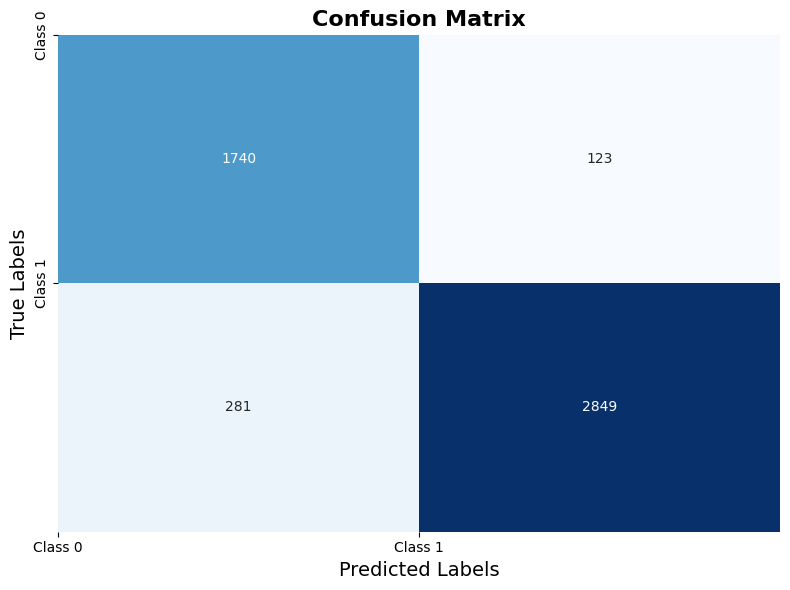

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Load the best model if not already loaded
best_model = load_model('new_best_model.h5')

# Predict classes for test data
y_pred = best_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Compute confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
plt.tight_layout()
plt.show()


Classification Report

In [ ]:
# Load the best model if not already loaded
best_model = load_model('new_best_model.h5')

# Compute classification report
class_labels = list(test_generator.class_indices.keys())
print('Classification Report:')
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

        fire       0.86      0.93      0.90      1863
      nofire       0.96      0.91      0.93      3130

    accuracy                           0.92      4993
   macro avg       0.91      0.92      0.91      4993
weighted avg       0.92      0.92      0.92      4993



Plotting training and validation loss

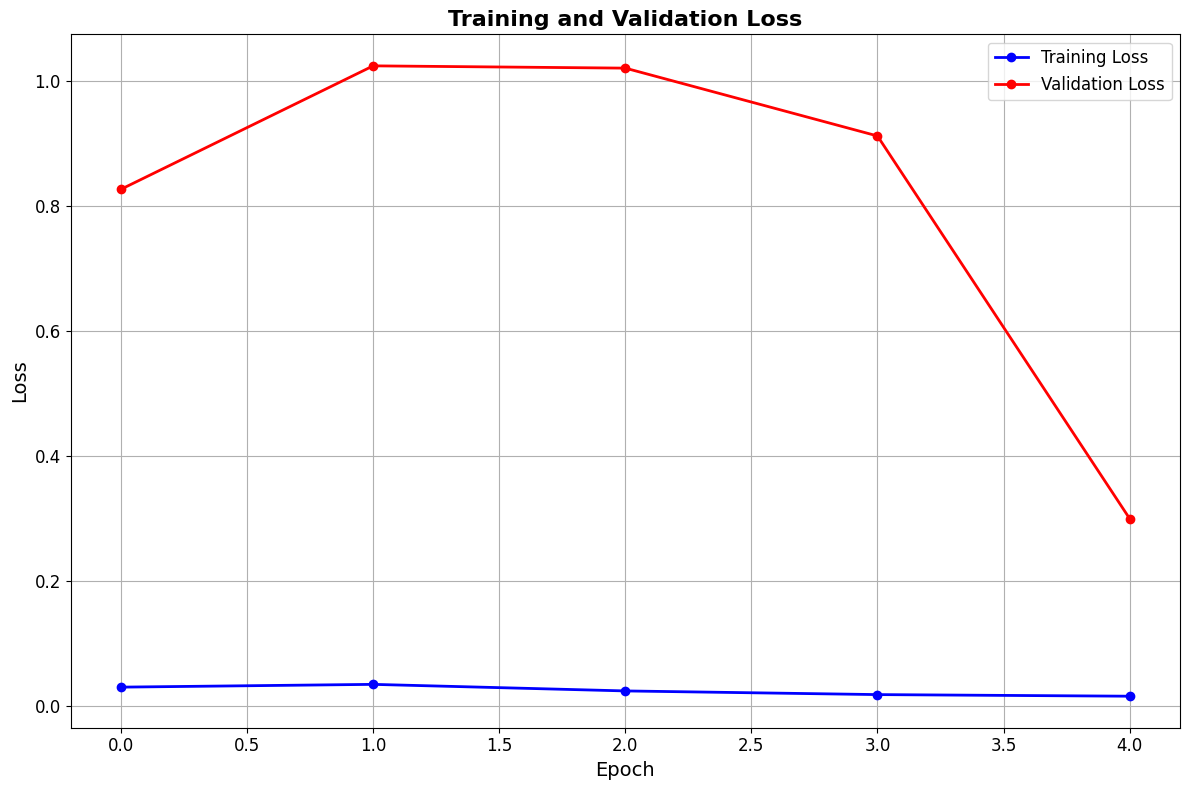

In [ ]:
# Load the best model
best_model = load_model('new_best_model.h5')

# Plot training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history_continued.history['loss'], color='b', marker='o', linestyle='-', label='Training Loss', linewidth=2)
plt.plot(history_continued.history['val_loss'], color='r', marker='o', linestyle='-', label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


Plotting training and validation accuracy

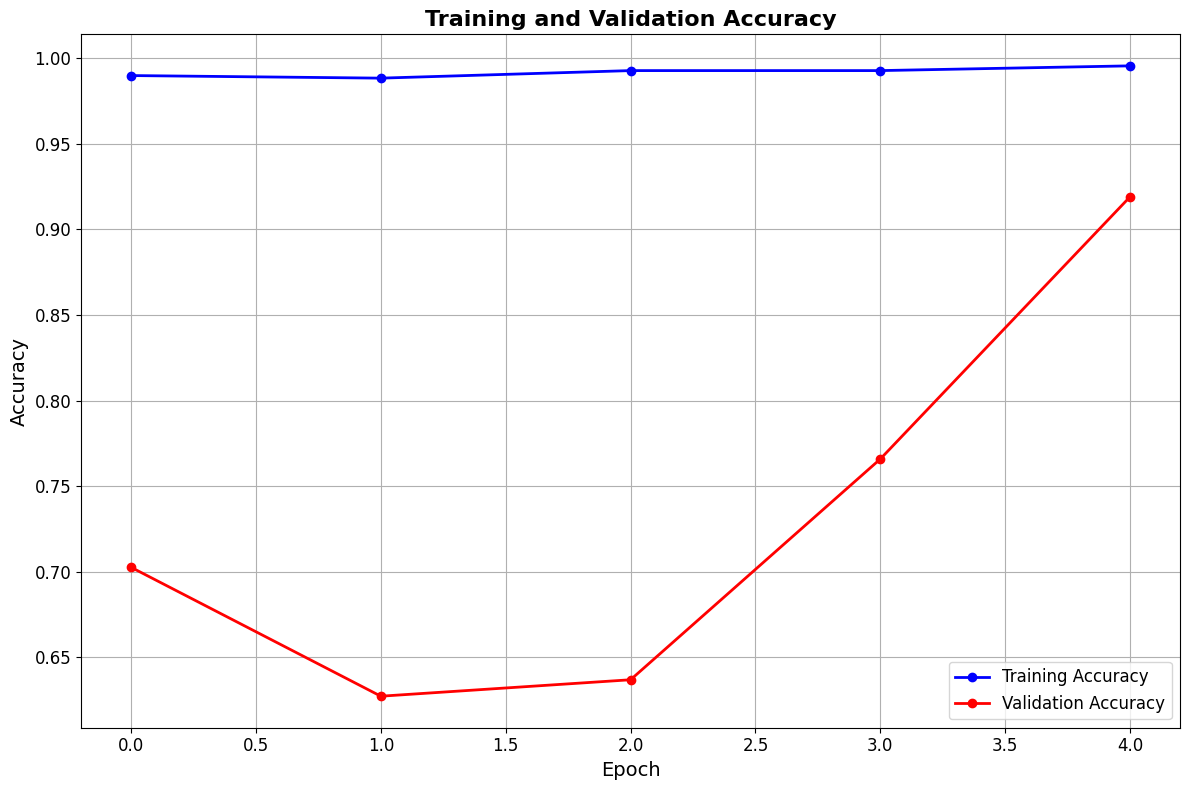

In [ ]:
# Load the best model
best_model = load_model('new_best_model.h5')

# Plot training and validation accuracy
plt.figure(figsize=(12, 8))
plt.plot(history_continued.history['accuracy'], color='blue', marker='o', linestyle='-', label='Training Accuracy', linewidth=2)
plt.plot(history_continued.history['val_accuracy'], color='red', marker='o', linestyle='-', label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()


Plotting the ROC Curve

157/157 [==============================] - 367s 2s/step


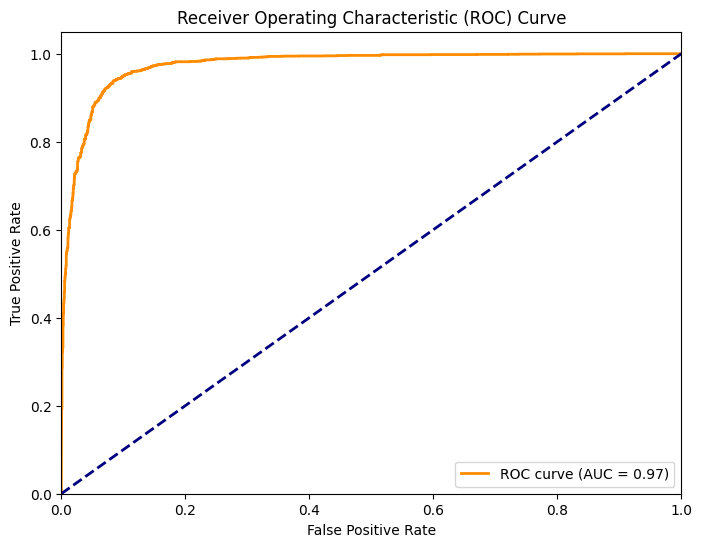

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('new_best_model.h5')

# Function to plot ROC curve and return AUC
def plot_roc_curve(model, test_generator):
    y_pred = model.predict(test_generator)

    # Check if the problem is multiclass
    if y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    else:
        y_pred = y_pred.squeeze()

    y_true = test_generator.classes

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# Plot ROC curve and get AUC
auc_value = plot_roc_curve(best_model, test_generator)


Plotting the AUC as a Bar Plot

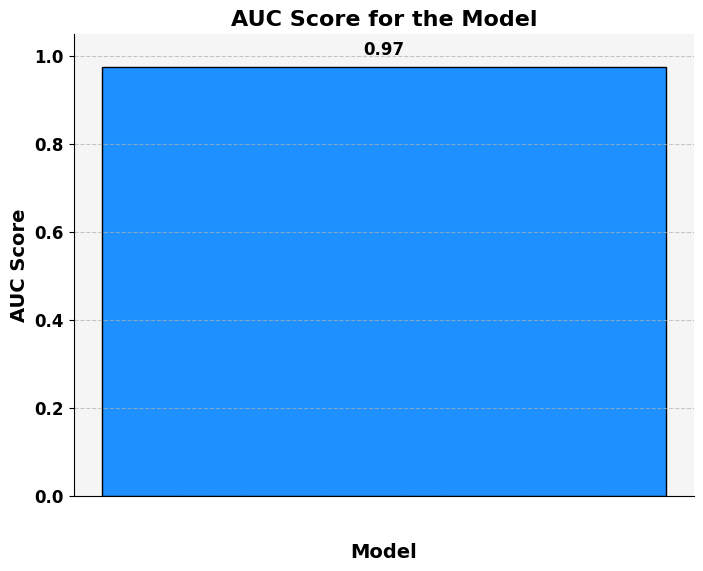

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot AUC bar plot
def plot_auc_bar(auc_value):
    plt.figure(figsize=(8, 6))
    bar_width = 0.5
    index = np.arange(1)

    bars = plt.bar(index, [auc_value], bar_width, color='dodgerblue', edgecolor='black')

    # Add AUC value on top of the bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    # Customize the plot
    plt.ylabel('AUC Score', fontsize=14, fontweight='bold')
    plt.title('AUC Score for the Model', fontsize=16, fontweight='bold')
    plt.ylim(0.0, 1.05)
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks([])

    # Add background color and border
    plt.gca().set_facecolor('whitesmoke')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Add annotation for AUC interpretation
    plt.annotate('Higher AUC indicates better model performance', xy=(0.5, 1.02), xytext=(0.5, 1.1),
                 textcoords='axes fraction', ha='center', fontsize=12, fontstyle='italic', color='darkblue')

    # Add the x-axis label below the plot
    plt.text(0.5, -0.1, 'Model', ha='center', va='top', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)

    plt.show()

# Plot AUC bar plot
plot_auc_bar(auc_value)
